In [1]:
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
os.chdir('/home/vco/Projects/pm4py-dcr') # working directory should be pm4py-dcr (the one behind notebooks)
print(os.getcwd())

/home/vco/Projects/pm4py-dcr/notebooks
/home/vco/Projects/pm4py-dcr


In [2]:
import pm4py
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
from scipy import stats
from pm4py.algo.discovery.dcr_discover import algorithm as alg
from pm4py.objects.dcr.exporter import exporter as dcr_exporter
import networkx as nx

In [3]:
A,B,X,Y,Z = 'A','B','X','Y','Z'
dcr1 = {'events': {A,B,X,Y,Z},
       'excludesTo': {
           X: {X,Y,A,B},
           Y: {Y,X,A},
           Z: {A},
           A: {X}
       }}
# result should be {X,Y} or {A,X} but A is not self-excluding itself

In [4]:
dcr2 = {'events': {A,B,X,Y,Z},
       'excludesTo': {
           X: {Y,X,Z},
           Y: {X,Z,Y},
           Z: {Y,Z,X},
           A: {B,A,Z},
           B: {B,A}
       }}
# result should be {X,Y,Z}, {A,B}

In [11]:
# dfs approach for mutual exclusion

# begin function1
def find_largest(e,E_stack,graph,S=None):
    # remove e from E
    if e in E_stack:
        E_stack.remove(e)
    # add e to a subprocess candidate S
    if S is None:
        S = set()
    S.add(e)
    # loop through the events in E using e_prime
    while len(E_stack)>0:
        e_prime = E_stack.pop()
        # check if e_prime is mutually excluded by all events in S
        if (e_prime in graph and e in graph[e_prime]) and (e in graph and e_prime in graph[e]):
            # if yes then GOTO begin function (add e_prime to the set S and remove e_prime from E)
            find_largest(e_prime,E_stack,graph,S)

    # return S
    return S

# begin function2
def get_cluster(dcr):
    # initialize an empty dict of subprocesses
    sp = {}
    i = 0
    # keep only the mutually excluded events E and the related graph
    graph = dcr['excludesTo']
    E = set()
    for k,v in graph.items():
        E.add(k)
        E = E.union(v)
    for e in E:
        E_stack = []
        for j in E:
            E_stack.append(j)
        # call function1 with e E graph return S
        s = find_largest(e,E_stack,graph)
        # if S > 1 add to subprocess list
        if len(s) > 1:
            already_there = False
            for k, v in sp.items():
                if v == s:
                    already_there = True
                    break
            if not already_there:
                sp[f'S{i}'] = s
                i = i + 1

    # return subprocess list
    return sp

get_cluster(dcr2)

{'S0': {'X', 'Y', 'Z'}, 'S1': {'A', 'B'}}

In [31]:
def get_cluster(dcr):
    cluster = set()
    for e1 in dcr['events']:
        if e1 in dcr['excludesTo']:
            for e2 in dcr['excludesTo'][e1]:
                if e2!=e1 and e2 in dcr['excludesTo'] and e1 in dcr['excludesTo'][e2]:
                    cluster.add(e1)

    return cluster

def find_clusters(dcr):
    dcr = deepcopy(dcr)
    print(dcr['events'])
    while len(dcr['events'])>0:
        res = get_cluster(dcr)
        print(dcr['events'])
        dcr['events'] = dcr['events'].difference(res)

In [32]:
find_clusters(dcr2)

{'Z', 'B', 'X', 'A', 'Y'}
{'Z', 'B', 'X', 'A', 'Y'}
{'Z', 'B', 'X', 'A', 'Y'}


In [16]:
graph = dcr['excludesTo']
E = dcr['events']
e1 = next(iter(E))
def findLargest(graph, E, e1, S=None):
    if S is None:
        S = set()
    S.add(e1)
    if e1 in graph:
        for e2 in graph[e1]:
            if e2!=e1 and e2 in graph and e1 in graph[e2]:
                S.add(e2)
                E.discard(e2)
                S_prime = findLargest(graph,E,e2,S)
                if S_prime>S:
                    S = S_prime
    return S

findLargest(graph,E,e1)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [38]:
g = Graph(dcr2['events'])
for e1, vals in dcr2['excludesTo'].items():
    for v in vals:
        g.addEdge(e1,v)
g.printSCCs()

[[4], [3], [2], [1], [0]]

In [67]:
# Strict based on both directions for both events
clusters = {}
# for i in range(len(dcr['events'])):
#     clusters[i] = set()
k=0
for (e1,e2) in cluster_pair:
    for (e3,e4) in cluster_pair:
        if e1!=e3 and e2!=e4:
            if e1==e4 and e2==e3:
                # they are in both directions (X,Y) <-> (Y,X)
                # now check if (e1,e2) has other pairs to cluster with, that respect:
                # (e1,e5) (e2,e5) (e1,e6) (e2,e5) OR (e5,e1) (e5,e2) (e6,e1) (e6,e2) are in the cluster
                if k != 0:
                    for (e5, e6) in cluster_pair:
                        if ((e1,e5) in cluster_pair and (e2,e5) in cluster_pair and (e1,e6) in cluster_pair and (e2,e5) in cluster_pair) or ((e5,e1) in cluster_pair and (e5,e2) in cluster_pair and (e6,e1) in cluster_pair and (e6,e2) in cluster_pair) and e1!=e5 and e2!=e6 and e1!=e6 and e2!=e5:
                            # now I want to create disjoint sets of events that are individual clusters
                            # here I get confused because I have to add new ones to the correct cluster
                            match_found = False
                            for j in range(k):
                                if e1 in clusters[j] and e2 in clusters[j]:
                                    clusters[j].add(e5)
                                    clusters[j].add(e6)
                                    match_found = True
                                    break
                            if match_found:
                                break
                    is_in_previous_cluster = 0
                    for j in range(k):
                        if e1 in clusters[j] and e2 in clusters[j]: #and set([e1,e2]).isdisjoint(clusters[j]):
                           is_in_previous_cluster = is_in_previous_cluster + 1
                    if is_in_previous_cluster == 0:
                        clusters[k] = set([e1,e2])
                        k = k + 1
                    else:
                        break
                elif k == 0:
                    clusters[k] = set([e1,e2])
                    k = k + 1
                    break

clusters

{0: {'A', 'X'}, 1: {'X', 'Y'}}

In [22]:
# Relaxed based on connected components
G = nx.Graph()
G.add_edges_from(cluster_pair)
for connected_component in nx.connected_components(G):
    print(connected_component)

{'Y', 'X', 'A'}


In [63]:
def find_mutual_exclusion_clusters(dcr):
    #based on connected components
    cluster_pair = set()
    ee = set()
    for e1 in dcr['events']: # for all events e1
        if e1 in dcr['excludesTo']: # if e1 -->% (any e in DCR)
            for e2 in dcr['excludesTo'][e1]: # for all e2 in e1 -->% e2
                if e2 in dcr['excludesTo'] and e1 in dcr['excludesTo'][e2]:# and e2!=e1:
                    # if e1 not the same as e2 and e2 -->% e1 then it is an edge in the graph
                    cluster_pair.add((e1, e2))
                    ee.add(e1)
                    ee.add(e2)
    return cluster_pair,ee

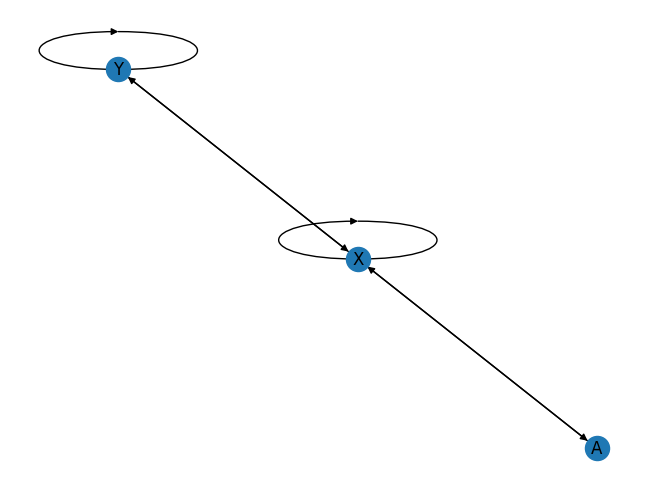

In [68]:
# events = dcr1['events']
cluster_pair, ee = find_mutual_exclusion_clusters(dcr1)
G = nx.DiGraph()
G.add_edges_from(cluster_pair)
cc = nx.kosaraju_strongly_connected_components(G)
# fig,axs = plt.subplots(sum(1 for c in cc),1)
# i = 0
for c in cc:
    cG = deepcopy(G)
    for k in ee.difference(c):
        cG.remove_node(k)
    nx.draw(cG,with_labels=True)
    # i = i +1
# nx.draw(G,with_labels=True)

# TWO PROBLEMS TO SOLVE:
Only add an edge -- in G if there is a <--> between the notes in the digraph.
All nodes must be connected to each other.
If you want to be strict intersect with the atMostOnce
If there are cuts to be discovered in the mutual exclusion algorithm then it becomes a choice in relation to some optimization as to which subprocess to create.

Nothing works anymore.

TODO: implement my own simplicity and control flow complexity and some precission recall, F1 score bla bla bla

In [90]:
dcr = dcr1
adj_df = pd.DataFrame(columns=sorted(dcr['events']),index=sorted(dcr['events']),dtype=int)
adj_df = adj_df.fillna(0)
for e1 in dcr['events']:
    for e2 in dcr['events']:
        if e1 in dcr['excludesTo'] and e2 in dcr['excludesTo'][e1]:
            adj_df.loc[e1,e2] = 1
        if e2 in dcr['excludesTo'] and e1 in dcr['excludesTo'][e2]:
            adj_df.loc[e2,e1] = 1
adj_df = adj_df.astype(int)

In [91]:
adj_df

,A,B,X,Y,Z
A,0,0,1,0,0
B,0,0,0,0,0
X,1,1,1,1,0
Y,1,0,1,1,0
Z,1,0,0,0,0


In [92]:
adj_df.T

,A,B,X,Y,Z
A,0,0,1,1,1
B,0,0,1,0,0
X,1,0,1,1,0
Y,0,0,1,1,0
Z,0,0,0,0,0


In [93]:
adj_df + adj_df.T

,A,B,X,Y,Z
A,0,0,2,1,1
B,0,0,1,0,0
X,2,1,2,2,0
Y,1,0,2,2,0
Z,1,0,0,0,0
